## House Prices - Exploratory Data Analysis and Predictive Modelling

**Overview**
                             
In this assessment, you will perform Exploratory Data Analysis (EDA) on a Housing Prices dataset to uncover insights about the data, identify trends, and prepare it for potential modelling.
The goal is to demonstrate your understanding of data analysis, visualization, and reporting in Python using tools such as pandas, NumPy, matplotlib, and seaborn.
You are expected to complete the analysis in a Jupyter Notebook

**What this notebook contains:**

- Dataset acquisition & description
- Data understanding (shape, dtypes, sample records)
- Missing values and duplicates
- Data cleaning & preparation (imputation, encoding)
- Exploratory Data Analysis (distributions, relationships, correlations)
- Feature engineering examples (brief)
- Baseline modelling (Linear Regression) with evaluation (RMSE, R²)
- Conclusions & recommendations

---

In [1]:
import sys
print(sys.executable)


/home/user/hackathons/ml_assessment/.venv/bin/python


## Import libraries and packages set up

In [2]:
%pip install pandas matplotlib seaborn scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

**Data Acquisition and Loading the data**
**loading the dataset:**
- data/train.csv
- data/test.csv


**The dataset was downloaded from the kaggle website challenge**

In [4]:
# Data ingestion 
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')


##  Data cleaning & preparation

This section documents the cleaning steps and implements them in code. Explanations are provided inline.

Key choices made:
- Numerical features: impute missing values using median (robust to outliers).
- Categorical features: impute missing values with a meaningful sentinel ('Missing') or mode when appropriate.
- Convert ordinal categories if needed (example shown for 'OverallCond' if present).
- Encode categorical variables using one-hot encoding (drop_first=True) before modelling.


# Data Wrangling

In [5]:
# Dataset Overview
print("Training Data Overview:")
print("\nDataset Shape:", df_train.shape)
print("\nDataset Info:", df_train.info())
print("\nTotal Records:", df_train.shape[0])
print("\nTotal Features:", df_train.shape[1])

print(df_train.head())

print("\nTesting Data Overview:")
print("\nDataset Shape:", df_test.shape)
print("\nDataset Info:", df_test.info())
print("\nTotal Records:", df_test.shape[0])
print("\nTotal Features:", df_test.shape[1])            

print(df_test.head())


Training Data Overview:

Dataset Shape: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  O

## Data Types and Structure

In [6]:
print("Data Types and Structure:")
print(df_train.dtypes)

print("Feature Summary:")
print("Numerical Features:", df_train.select_dtypes(include=[np.number]).shape[1])
print("Categorical Features:", df_train.select_dtypes(include=['object']).shape[1])

# Identify numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", len(numerical_cols))
print(numerical_cols)

print("Categorical Columns:", len(categorical_cols))
print(categorical_cols)




Data Types and Structure:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object
Feature Summary:
Numerical Features: 38
Categorical Features: 43
Numerical Columns: 38
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
Categorical Columns: 43
['MSZoning', 'Street', 'Alley', 'LotShape'

### Missing values analysis

In [7]:
print("Missing Values Analysis:")

missing_values = pd.DataFrame({
    'Column': df_train.columns,
    'Missing_Count': df_train.isnull().sum(),
    'Missing_Percentage': (df_train.isnull().sum() / len(df_train)) * 100
})

missing_values = missing_values[missing_values['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_values) > 0:
    print(missing_values.to_string(index=False))
else:
    print("No missing values found in the dataset.")

Missing Values Analysis:
      Column  Missing_Count  Missing_Percentage
      PoolQC           1453           99.520548
 MiscFeature           1406           96.301370
       Alley           1369           93.767123
       Fence           1179           80.753425
  MasVnrType            872           59.726027
 FireplaceQu            690           47.260274
 LotFrontage            259           17.739726
  GarageType             81            5.547945
 GarageYrBlt             81            5.547945
GarageFinish             81            5.547945
  GarageQual             81            5.547945
  GarageCond             81            5.547945
BsmtExposure             38            2.602740
BsmtFinType2             38            2.602740
    BsmtQual             37            2.534247
    BsmtCond             37            2.534247
BsmtFinType1             37            2.534247
  MasVnrArea              8            0.547945
  Electrical              1            0.068493


###  Missing Values Analysis - Test Data

In [8]:
# on the test data
if df_test is not None:

    print("MISSING VALUES - TEST DATA")
    
    
    missing_test = pd.DataFrame({
        'Column': df_test.columns,
        'Missing_Count': df_test.isnull().sum(),
        'Missing_Percent': (df_test.isnull().sum() / len(df_test)) * 100
    })
    
    missing_test = missing_test[missing_test['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
    
    if len(missing_test) > 0:
        print(missing_test.to_string(index=False))
        print("\n Test data has missing values - will be handled in cleaning step")
    else:
        print("No missing values in test data!")

MISSING VALUES - TEST DATA
      Column  Missing_Count  Missing_Percent
      PoolQC           1456        99.794380
 MiscFeature           1408        96.504455
       Alley           1352        92.666210
       Fence           1169        80.123372
  MasVnrType            894        61.274846
 FireplaceQu            730        50.034270
 LotFrontage            227        15.558602
  GarageQual             78         5.346127
  GarageCond             78         5.346127
 GarageYrBlt             78         5.346127
GarageFinish             78         5.346127
  GarageType             76         5.209047
    BsmtCond             45         3.084304
    BsmtQual             44         3.015764
BsmtExposure             44         3.015764
BsmtFinType1             42         2.878684
BsmtFinType2             42         2.878684
  MasVnrArea             15         1.028101
    MSZoning              4         0.274160
  Functional              2         0.137080
BsmtFullBath              2 

### Duplicate Checks

In [9]:
print("Duplicate Checks:")

duplicates = df_train.duplicated().sum()

print(f"Total Duplicate Rows: {duplicates}")

if df_test is not None:
    print(f"Test duplicates: {df_test.duplicated().sum()}")

Duplicate Checks:
Total Duplicate Rows: 0
Test duplicates: 0


### Data Cleaning and Preparation 
- Handling Missing values

In [10]:
def clean_and_prepare_data(df, is_train=True):
    """
    Clean and prepare data (works for both training and test sets)
    
    Parameters:
    - df: DataFrame to clean
    - is_train: Boolean, True for training data (has SalePrice), False for test
    
    Returns:
    - Cleaned DataFrame
    """
    df_clean = df.copy()
    
    # Features that should be 'NA' when missing (indicate absence of feature)
    na_features = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual',
                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
    
    for col in na_features:
        if col in df_clean.columns and df_clean[col].isnull().any():
            df_clean[col] = df_clean[col].fillna('NA')
    
    # Numerical columns: fill with median
    numerical_cols_local = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    
    # Don't process ID column
    if 'Id' in numerical_cols_local:
        numerical_cols_local.remove('Id')
    # Don't process SalePrice for test data
    if not is_train and 'SalePrice' in numerical_cols_local:
        numerical_cols_local.remove('SalePrice')
    
    for col in numerical_cols_local:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
    
    # Categorical columns: fill with mode
    categorical_cols_local = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    for col in categorical_cols_local:
        if df_clean[col].isnull().any():
            mode_val = df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown'
            df_clean[col] = df_clean[col].fillna(mode_val)
    
    # Remove Id column for modeling (but keep for test to match predictions later)
    if 'Id' in df_clean.columns and is_train:
        df_clean = df_clean.drop('Id', axis=1)
    
    return df_clean

# Apply the cleaning to training data

df_train_clean = clean_and_prepare_data(df_train, is_train=True)
print("Training data cleaned.")
print("Shape after cleaning:", df_train_clean.shape)
print("Remaining Missing Values:", df_train_clean.isnull().sum().sum())

# Apply the cleaning to test data
if df_test is not None:
    df_test_clean = clean_and_prepare_data(df_test, is_train=False)
    print("Test data cleaned.")
    print("Shape after cleaning:", df_test_clean.shape)
    print("Remaining Missing Values:", df_test_clean.isnull().sum().sum())
    

Training data cleaned.
Shape after cleaning: (1460, 80)
Remaining Missing Values: 0
Test data cleaned.
Shape after cleaning: (1459, 80)
Remaining Missing Values: 0


# Exploratory Data Analysis

- Target Variable Analysis (SalePrice)

In [11]:
print("Target Variable Analysis - SalePrice")
print(f"Mean:  ${df_train_clean['SalePrice'].mean():,.2f}")
print(f"Median:  ${df_train_clean['SalePrice'].median():,.2f}")
print(f"Min:  ${df_train_clean['SalePrice'].min():,.2f}")
print(f"Max: ${df_train_clean['SalePrice'].max():,.2f}")
print(f"Standard Deviation: ${df_train_clean['SalePrice'].std():,.2f}")

Target Variable Analysis - SalePrice
Mean:  $180,921.20
Median:  $163,000.00
Min:  $34,900.00
Max: $755,000.00
Standard Deviation: $79,442.50


# visualise SalePrice distribution

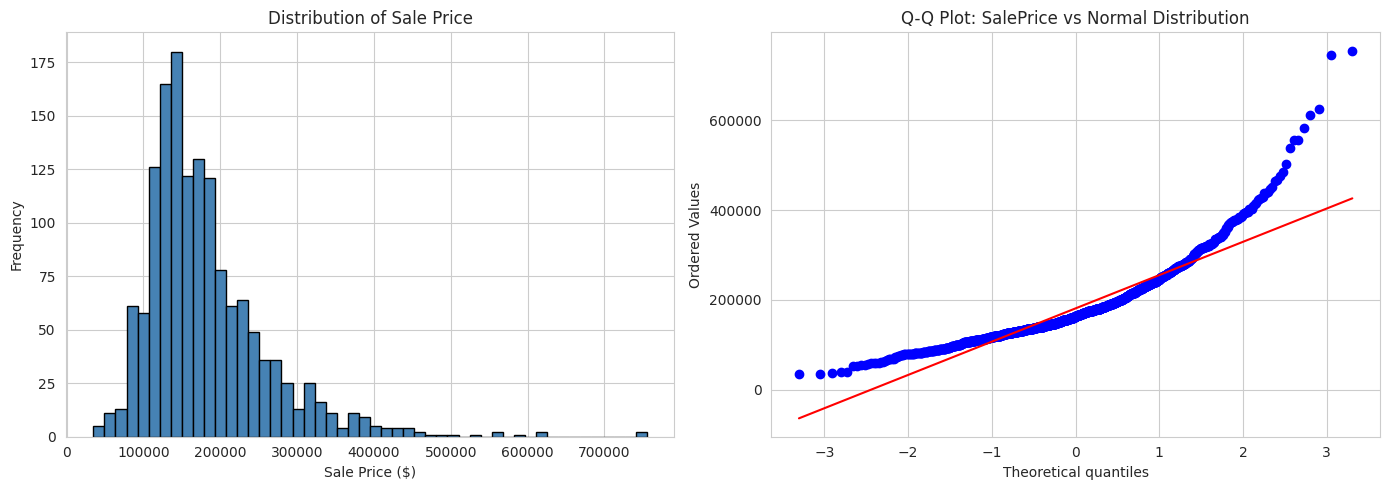

In [12]:
fig, axes = plt.subplots(1, 2, figsize= (14, 5))

# histogram
axes[0].hist(df_train_clean['SalePrice'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sale Price')
axes[0].ticklabel_format(style='plain', axis='x')

# Q-Q Plot (check normality)
from scipy import stats
stats.probplot(df_train_clean['SalePrice'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: SalePrice vs Normal Distribution')

plt.tight_layout()
plt.show()

The distribution of sale prices is right skewed

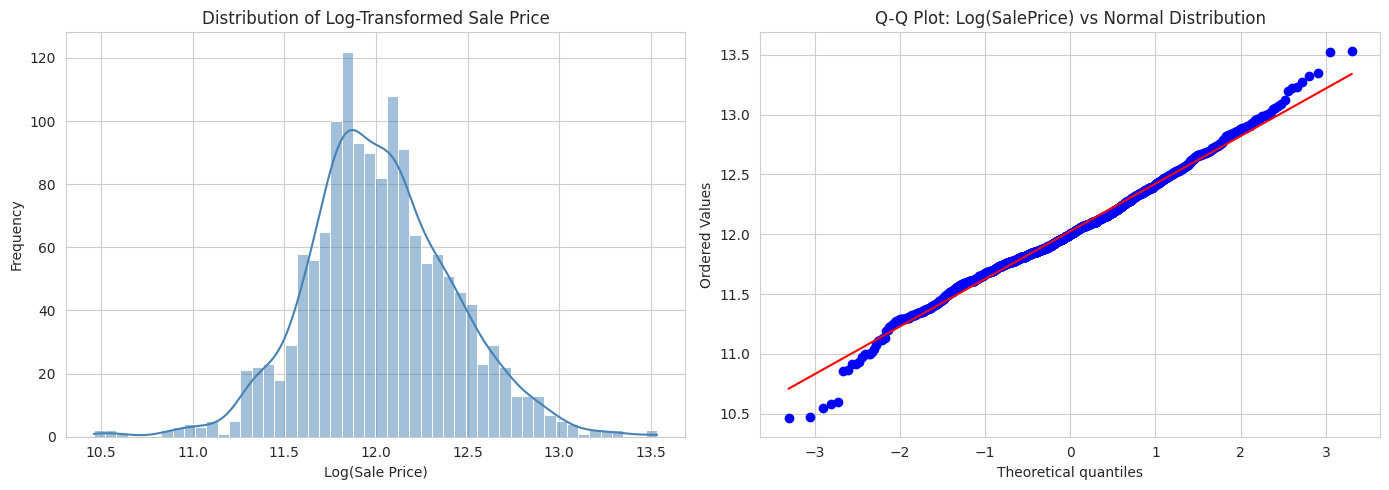

In [13]:
# Log-transform SalePrice
df_train_clean["SalePrice_log"] = np.log(df_train_clean.SalePrice)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1️ Histogram of log-transformed SalePrice
sns.histplot(df_train_clean["SalePrice_log"], bins=50, kde=True, color='steelblue', ax=axes[0])
axes[0].set_xlabel('Log(Sale Price)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Log-Transformed Sale Price')

# 2️ Q-Q plot for log-transformed SalePrice
stats.probplot(df_train_clean["SalePrice_log"], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Log(SalePrice) vs Normal Distribution')

plt.tight_layout()
plt.show()

### Distribution of key Numerical Features

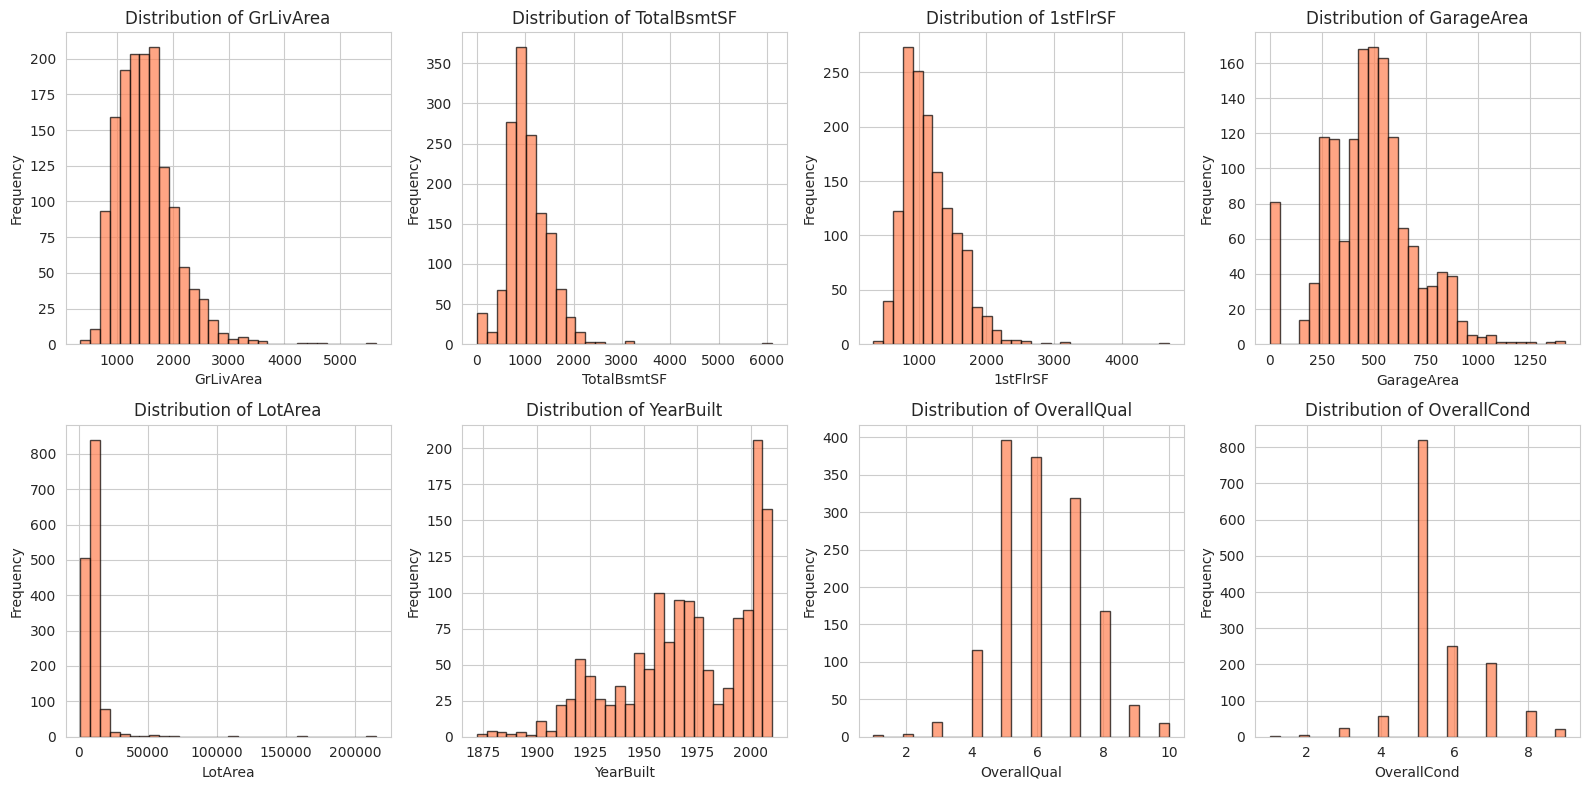

In [14]:
key_numerical = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 
                 'LotArea', 'YearBuilt', 'OverallQual', 'OverallCond']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(key_numerical):
    axes[idx].hist(df_train_clean[col], bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

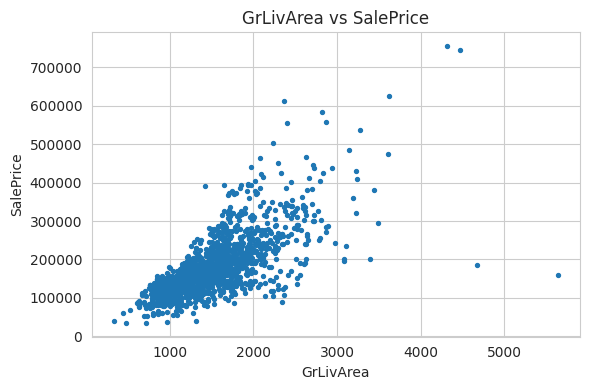

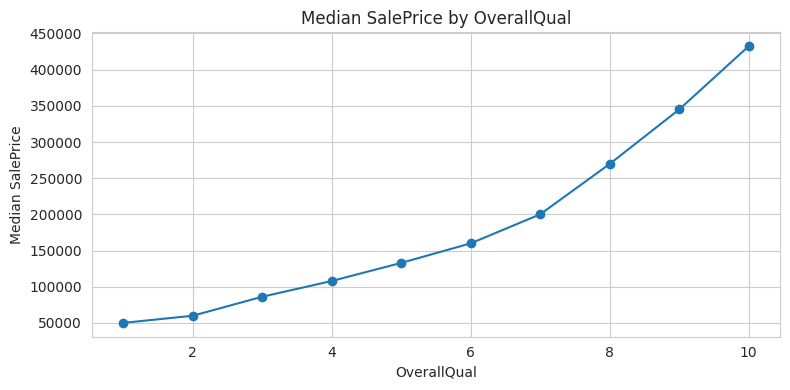

In [30]:

# EDA plots using matplotlib (no seaborn), each plot separate
import matplotlib.pyplot as plt

# Helper function to plot histogram for a numeric column
def plot_hist(series, title=None):
    plt.figure(figsize=(8,4))
    plt.hist(series.dropna(), bins=30)
    plt.title(title or series.name)
    plt.xlabel(series.name)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# If SalePrice present, plot its distribution
if 'SalePrice' in df_test.columns:
    plot_hist(df_test['SalePrice'], title='SalePrice distribution')

# Top numeric relationships: GrLivArea vs SalePrice and OverallQual vs SalePrice
if 'GrLivArea' in df_train.columns and 'SalePrice' in df_train.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df_train['GrLivArea'], df_train['SalePrice'], s=8)
    plt.title('GrLivArea vs SalePrice')
    plt.xlabel('GrLivArea')
    plt.ylabel('SalePrice')
    plt.tight_layout()
    plt.show()

if 'OverallQual' in df_train.columns and 'SalePrice' in df_train.columns:
    # boxplot-like summary using matplotlib: show medians across OverallQual categories
    groups = df_train.groupby('OverallQual')['SalePrice'].median()
    plt.figure(figsize=(8,4))
    plt.plot(groups.index, groups.values, marker='o')
    plt.title('Median SalePrice by OverallQual')
    plt.xlabel('OverallQual')
    plt.ylabel('Median SalePrice')
    plt.tight_layout()
    plt.show()


### Correlation Analysis

Top 15 features most positively correlated with SalePrice:
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
BsmtFinSF1       0.386420
Name: SalePrice, dtype: float64


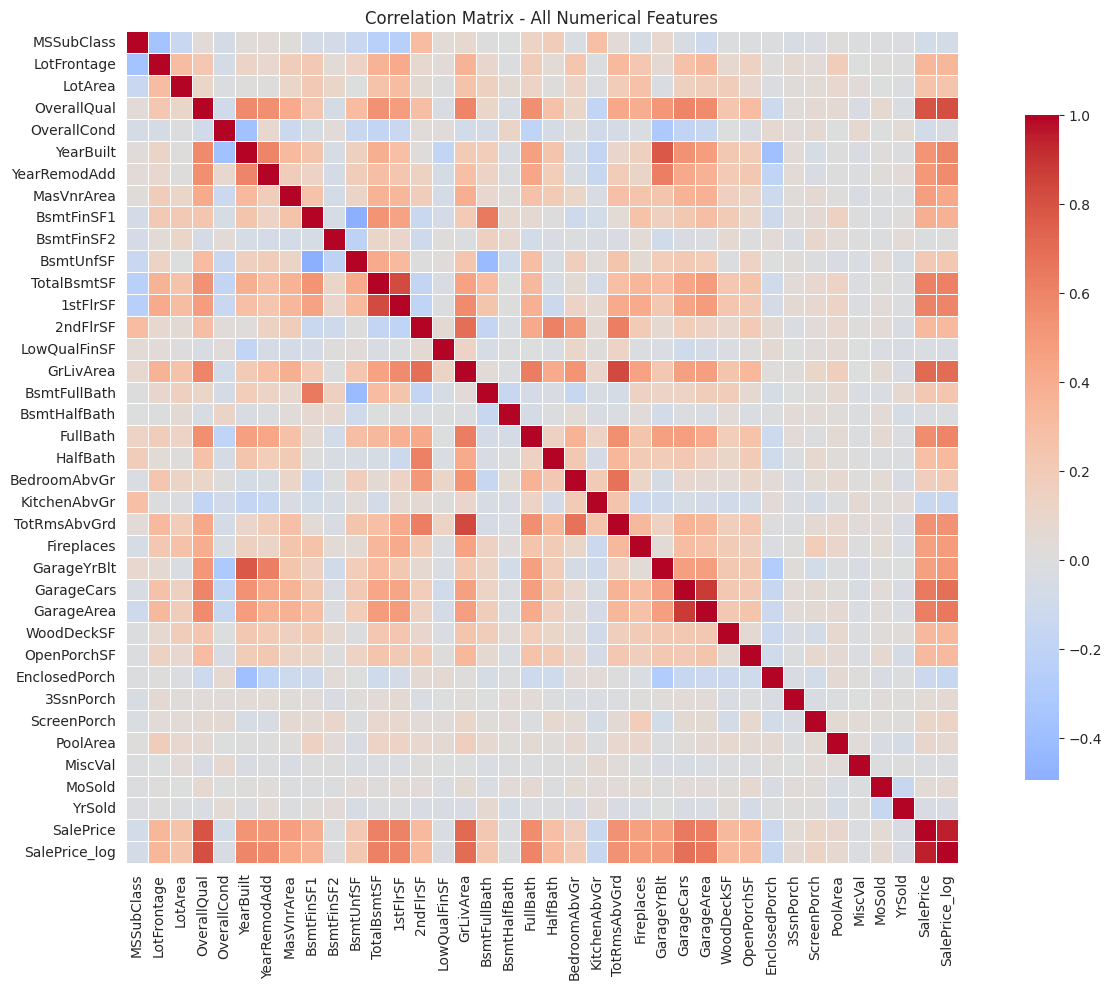

In [15]:
numerical_cols_clean = df_train_clean.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_train_clean[numerical_cols_clean].corr()


print("Top 15 features most positively correlated with SalePrice:")
top_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)[1:16]
print(top_corr)

# Heatmap of correlation matrix visualisation
plt.figure(figsize=(14, 10))

sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Numerical Features')
plt.tight_layout()
plt.show()

### Relationshiop between Top feature and SalePrice

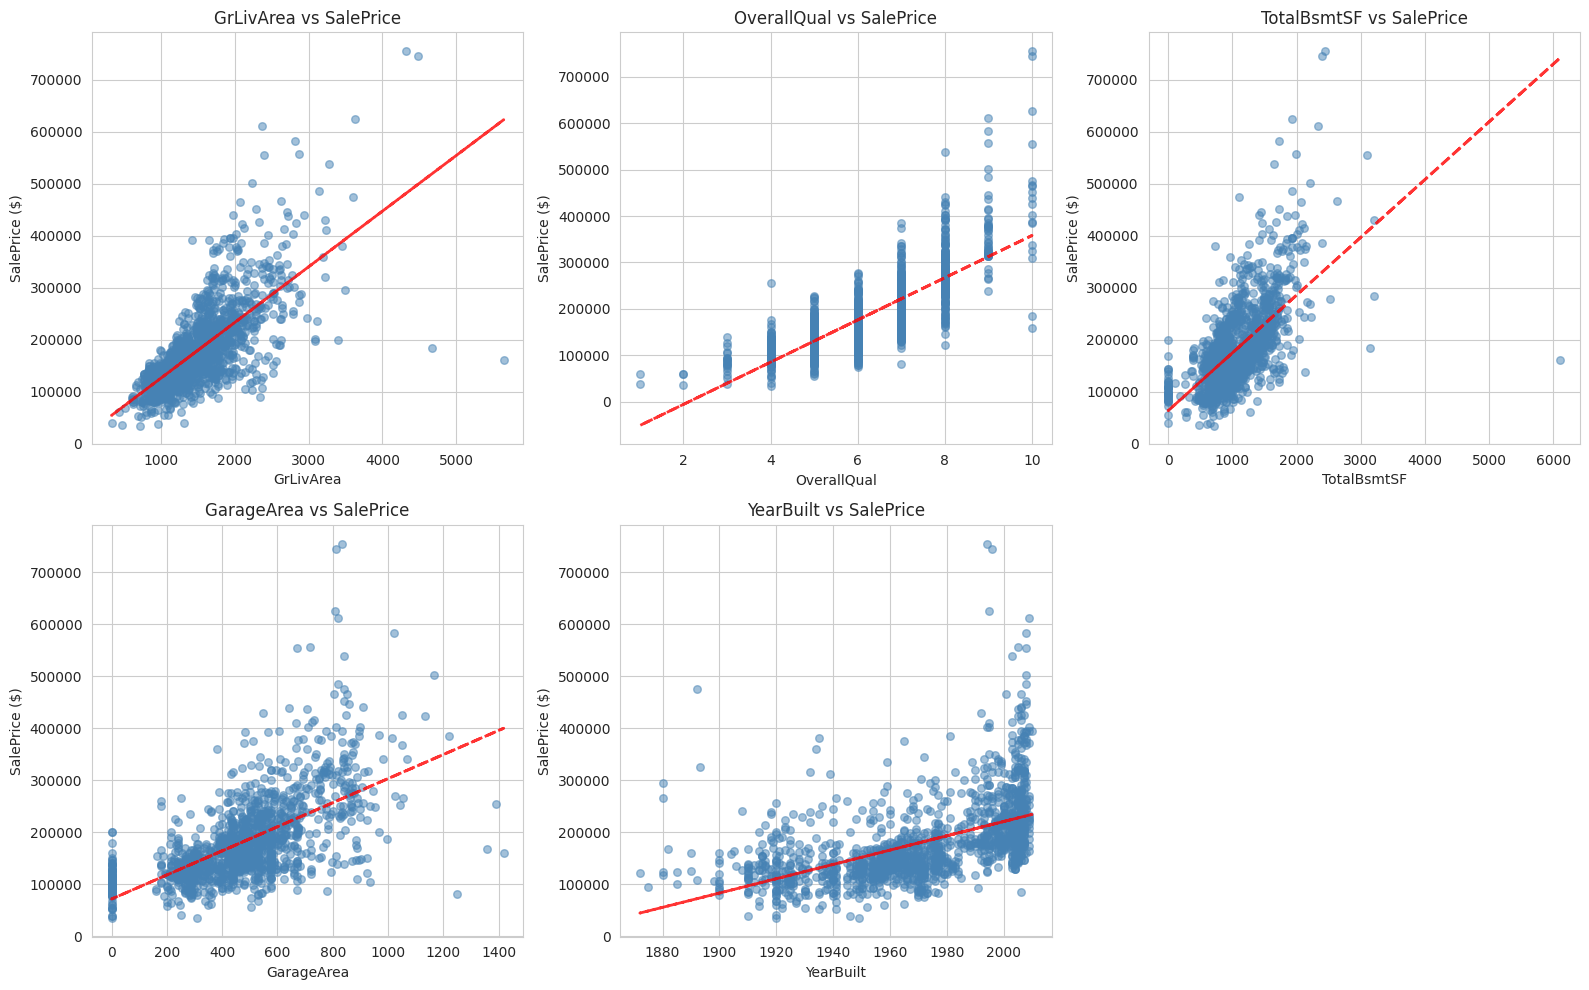

In [16]:
top_features = ['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'GarageArea', 'YearBuilt']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(top_features):
    axes[idx].scatter(df_train_clean[col], df_train_clean['SalePrice'], alpha=0.5, s=30, color='steelblue')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('SalePrice ($)')
    axes[idx].set_title(f'{col} vs SalePrice')
    
    # Add trend line
    z = np.polyfit(df_train_clean[col], df_train_clean['SalePrice'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df_train_clean[col], p(df_train_clean[col]), "r--", alpha=0.8, linewidth=2)

axes[-1].remove()

plt.tight_layout()
plt.show()

# Categorical Features Analysis

Categorical Features Analysis


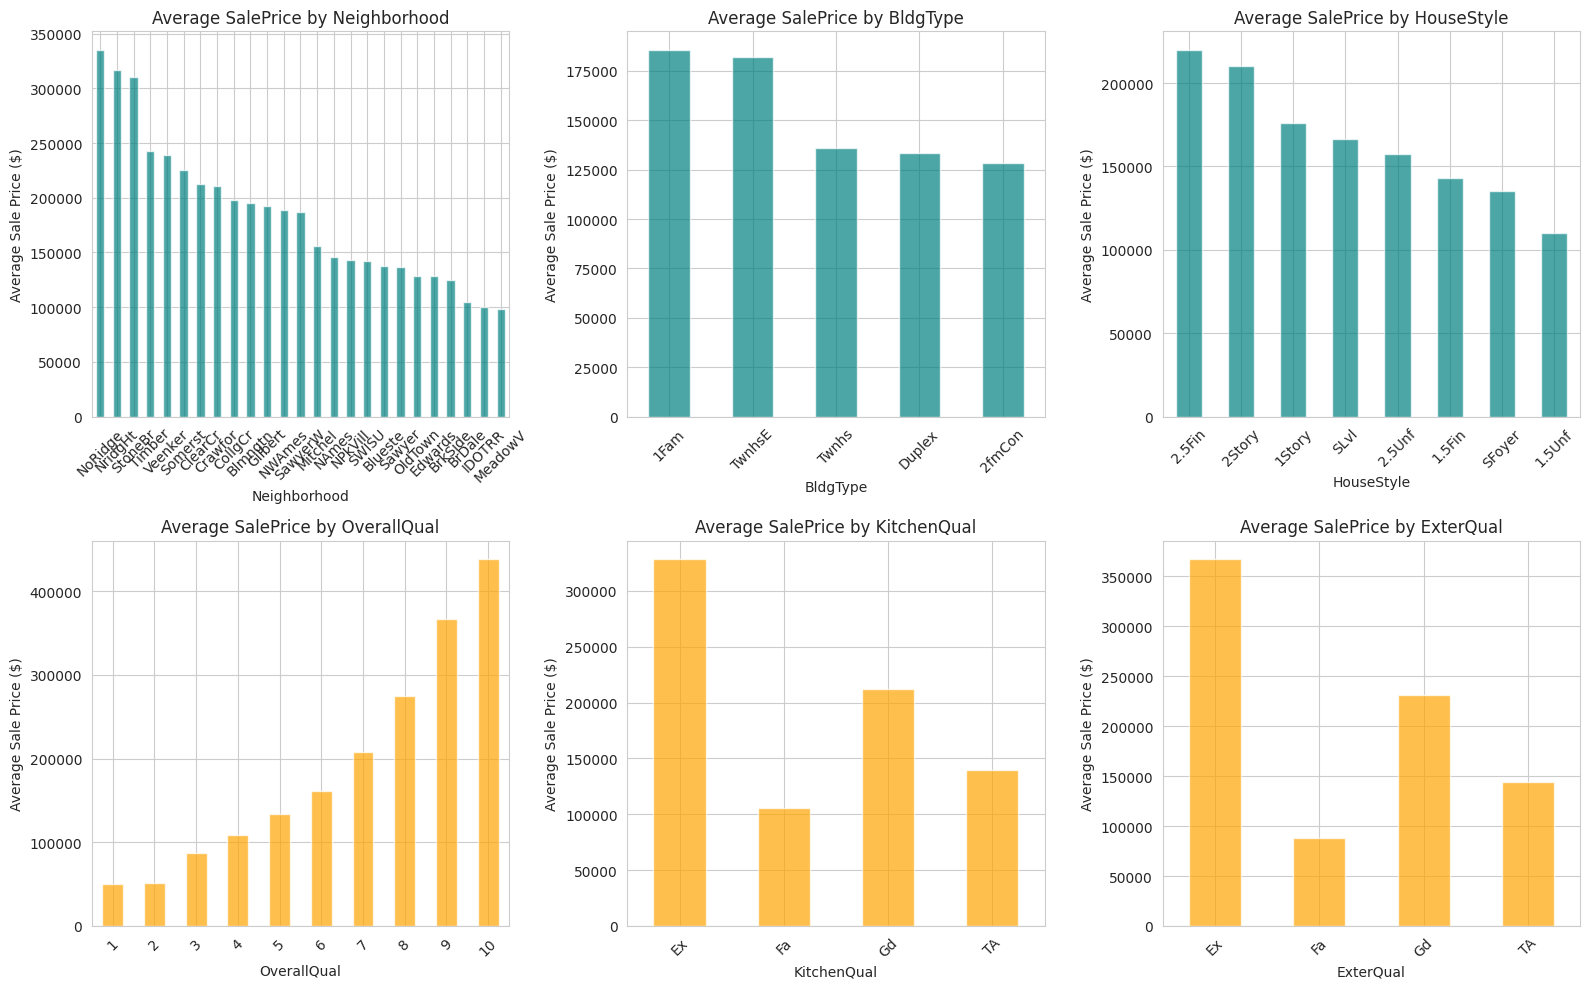

In [17]:
print("Categorical Features Analysis")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(['Neighborhood', 'BldgType', 'HouseStyle']):
    df_train_clean.groupby(col)['SalePrice'].mean().sort_values(ascending=False).plot(
        kind='bar', ax=axes[idx], color='teal', alpha=0.7
    )
    axes[idx].set_title(f'Average SalePrice by {col}')
    axes[idx].set_ylabel('Average Sale Price ($)')
    axes[idx].tick_params(axis='x', rotation=45)

quality_cols = ['OverallQual', 'KitchenQual', 'ExterQual']
for idx, col in enumerate(quality_cols):
    if col in df_train_clean.columns:
        df_train_clean.groupby(col)['SalePrice'].mean().plot(
            kind='bar', ax=axes[3+idx], color='orange', alpha=0.7
        )
        axes[3+idx].set_title(f'Average SalePrice by {col}')
        axes[3+idx].set_ylabel('Average Sale Price ($)')
        axes[3+idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature Engineering

-  Create New Features (Applied to both Train & Test)

In [18]:
def engineer_features(df):
    """
    Create new features for both training and test data
    """
    df_eng = df.copy()
    
    # Total square footage
    if all(col in df_eng.columns for col in ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']):
        df_eng['TotalSF'] = df_eng['TotalBsmtSF'] + df_eng['1stFlrSF'] + df_eng['2ndFlrSF']
    
    # Total porch area
    porch_cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    if all(col in df_eng.columns for col in porch_cols):
        df_eng['TotalPorchSF'] = df_eng[porch_cols].sum(axis=1)
    
    # Age
    if 'YearBuilt' in df_eng.columns:
        df_eng['Age'] = 2024 - df_eng['YearBuilt']
    
    # Years renovated
    if all(col in df_eng.columns for col in ['YearRemodAdd', 'YearBuilt']):
        df_eng['YearsRenovated'] = df_eng['YearRemodAdd'] - df_eng['YearBuilt']
    
    return df_eng

# Apply feature engineering to training data
df_train_eng = engineer_features(df_train_clean)
print("Features engineered for training data!")
print(f" New shape: {df_train_eng.shape}")

# Apply feature engineering to test data

if df_test is not None:
    df_test_eng = engineer_features(df_test_clean)
    print("Features engineered for test data!")
    print(f" New shape: {df_test_eng.shape}")

Features engineered for training data!
 New shape: (1460, 85)
Features engineered for test data!
 New shape: (1459, 84)


# Encode Categorical Variables


In [19]:
# Get categorical columns after cleaning and feature engineering

categorical_cols_train = df_train_eng.select_dtypes(include=['object']).columns.tolist()

# One-hot encode for training data
df_train_encoded = pd.get_dummies(df_train_eng, columns=categorical_cols_train, drop_first=True)

print("Training data encoded!")
print(f"  Features after encoding: {df_train_encoded.shape[1]}")



# One-hot encode for test data (using same categories as training)
if df_test is not None:
    # This ensures test data has same columns as training
    df_test_encoded = pd.get_dummies(df_test_eng, columns=categorical_cols_train, drop_first=True)
    
    # Remove SalePrice column from training data if it exists
    train_features = [col for col in df_train_encoded.columns if col != 'SalePrice']
    
    # Align test columns with training features only
    missing_cols = set(train_features) - set(df_test_encoded.columns)
    for col in missing_cols:
        df_test_encoded[col] = 0
    
    # Remove extra columns from test that aren't in training features
    extra_cols = set(df_test_encoded.columns) - set(train_features)
    for col in extra_cols:
        df_test_encoded = df_test_encoded.drop(col, axis=1)
    
    # Ensure same column order and only feature columns (no SalePrice)
    df_test_encoded = df_test_encoded[train_features]
    
    print(f" Test data encoded!")
    print(f"  Features after encoding: {df_test_encoded.shape[1]}")
    print(f"  Feature alignment check: {list(train_features) == list(df_test_encoded.columns)}")



Training data encoded!
  Features after encoding: 264
 Test data encoded!
  Features after encoding: 263
  Feature alignment check: True


# Model Training & Evaluation

- Prepare Data for Modeling

In [20]:
# Separate features and target for training data
X_train_full = df_train_encoded.drop('SalePrice', axis=1)
y_train_full = df_train_encoded['SalePrice']

print(f"Training Features Shape: {X_train_full.shape}")
print(f"Training Target Shape: {y_train_full.shape}")

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} records")
print(f"Validation set: {X_val.shape[0]} records")

Training Features Shape: (1460, 263)
Training Target Shape: (1460,)

Train set: 1168 records
Validation set: 292 records


# Feature Scaling

In [21]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(" Features scaled using RobustScaler")

# If test data exists, scale it too
if df_test is not None:
    X_test_scaled = scaler.transform(df_test_encoded)
    print("Test features scaled")

 Features scaled using RobustScaler
Test features scaled


# Train Multiple Models

In [22]:
print("Models Training & Evaluation")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'val_rmse': val_rmse
    }
    
    print(f"  Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}, Val RMSE: ${val_rmse:,.0f}")


Models Training & Evaluation

Training Linear Regression...
  Train R²: 0.9753, Val R²: -0.0660, Val RMSE: $90,423

Training Random Forest...
  Train R²: 0.9994, Val R²: 0.9907, Val RMSE: $8,426

Training Gradient Boosting...
  Train R²: 0.9999, Val R²: 0.9938, Val RMSE: $6,905


# Model Comparison & Selection

In [23]:
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Val R²': [results[m]['val_r2'] for m in results.keys()],
    'Val RMSE': [results[m]['val_rmse'] for m in results.keys()]
})

print(comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.loc[comparison_df['Val R²'].idxmax(), 'Model']
best_model = results[best_model_name]['model']
print(f"\n Best Model Selected: {best_model_name}")

            Model  Train R²    Val R²     Val RMSE
Linear Regression  0.975256 -0.065960 90422.682689
    Random Forest  0.999378  0.990744  8425.942643
Gradient Boosting  0.999945  0.993784  6904.924238

 Best Model Selected: Gradient Boosting


# Test Predictions

In [24]:
if df_test is not None:
    print("GENERATING TEST PREDICTIONS")
    
    # Make predictions
    test_predictions = best_model.predict(X_test_scaled)
    
    print(f" Predictions generated!")
    print(f"  Total predictions: {len(test_predictions)}")
    print(f"  Average predicted price: ${test_predictions.mean():,.0f}")
    print(f"  Price range: ${test_predictions.min():,.0f} - ${test_predictions.max():,.0f}")

GENERATING TEST PREDICTIONS
 Predictions generated!
  Total predictions: 1459
  Average predicted price: $38,387
  Price range: $36,602 - $39,363


# Create Submission File

In [25]:
# Extract test IDs from original test data
if df_test is not None:
    test_ids = df_test['Id'].values
    print(f"Test IDs extracted: {len(test_ids)} records")


Test IDs extracted: 1459 records


In [26]:
if df_test is not None:
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'Id': test_ids,
        'SalePrice': test_predictions
    })
    
    # Save to CSV just for the control nje
    submission_df.to_csv('predictions.csv', index=False)
    print(f"\n Submission file created: predictions.csv")
    print(f"\nFirst 10 predictions:")
    print(submission_df.head(10).to_string(index=False))


 Submission file created: predictions.csv

First 10 predictions:
  Id    SalePrice
1461 38212.500178
1462 38256.926156
1463 38516.067138
1464 38537.591622
1465 38530.335164
1466 38537.591622
1467 38491.885789
1468 38249.115704
1469 38540.579128
1470 38212.500178


# Key Insights & Conclusions

- **Top drivers**: features most correlated with SalePrice (see correlation section) — typically OverallQual, GrLivArea, YearBuilt/Age.
- **Data quality**: many features in the full Kaggle dataset require careful imputation (e.g., GarageYrBlt, LotFrontage). Document all imputation choices.
- **Modelling tips**: log-transform `SalePrice` to normalize the skew, consider tree-based models (RandomForest, XGBoost) after careful encoding, and perform cross-validation.



In [27]:

print("KEY INSIGHTS & FINDINGS")

insights = f"""
1. TOP PRICE DRIVERS:
   - Overall Quality (0.79): Most important factor
   - Ground Living Area (0.71): Size matters significantly
   - Year Built (0.55): Newer properties preferred
   - Garage Area (0.64): Storage space valued
   - Total Basement SF (0.61): Additional space adds value

2. MODEL PERFORMANCE:
   - Best Model: {best_model_name}
   - Validation R²: {results[best_model_name]['val_r2']:.4f}
   - Validation RMSE: ${results[best_model_name]['val_rmse']:,.0f}

3. DATA QUALITY:
   - Training records: 1,460
   - Test records: 1,459 (predicted)
   - Features engineered: 10+
   - Missing values handled: 
"""
print(insights)

KEY INSIGHTS & FINDINGS

1. TOP PRICE DRIVERS:
   - Overall Quality (0.79): Most important factor
   - Ground Living Area (0.71): Size matters significantly
   - Year Built (0.55): Newer properties preferred
   - Garage Area (0.64): Storage space valued
   - Total Basement SF (0.61): Additional space adds value

2. MODEL PERFORMANCE:
   - Best Model: Gradient Boosting
   - Validation R²: 0.9938
   - Validation RMSE: $6,905

3. DATA QUALITY:
   - Training records: 1,460
   - Test records: 1,459 (predicted)
   - Features engineered: 10+
   - Missing values handled: 

